In [288]:
# The workflow of this code consists of three parts:
# 1. Data Cleaning (the code was written in Jupiter notebooks and then incorporated into Google Colab)
# 2. Calculating Medians (more robust against outliers) and Distributions
# 3. Machine Learning Models
# Each step includes code for visualization.

In [289]:
# PART I: DATA CLEANING (converting data types, removing nulls & duplicates, create agg. values like profit, etc)
# Import Python Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import dependencies for Machine Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer


In [290]:
# Please UPLOAD the "movie_metadata.csv" file from the Resources folder to the same directory level as this code in Google Colab.

# Load the uploaded Excel file.
file_path = 'movie_metadata.csv'
# Set variable as the origibnal data
data_origin = pd.read_csv(file_path)
# Create a copy of the original data to keep it intactin case of any bugs
data = data_origin.copy()
# Display the first few rows of the dataset to understand its structure
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [291]:
# Clean the 'movie_title' column by removing 'Â' and any additional whitespace at the end
data['movie_title'] = data['movie_title'].str.replace('Â', '', regex=True).str.strip()
# Change the order of the columns and drop

In [292]:
# Change column order starting with defining the new column order
# Drop columns 'movie_imdb_link' and 'aspect_ratio'.
new_column_order = [
    'movie_title', 'gross', 'budget',  # Main movie details
    'actor_1_name', 'actor_1_facebook_likes',  # Actor 1 details
    'actor_2_name', 'actor_2_facebook_likes',  # Actor 2 details
    'actor_3_name', 'actor_3_facebook_likes',  # Actor 3 details
    'director_name', 'director_facebook_likes',  # Director details
    'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews',  # Movie-specific details
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',  # User and cast data
    'movie_facebook_likes',  # Add this column here
    'plot_keywords', 'genres', 'language', 'country', 'content_rating', 'imdb_score', 'color',  # Other features
]

# Reorder the DataFrame based on the new column order
data = data[new_column_order]

# Check the first three of our restructured data
print(data.head(3))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   
2                                   Spectre  200074175.0  245000000.0   

      actor_1_name  actor_1_facebook_likes      actor_2_name  \
0      CCH Pounder                  1000.0  Joel David Moore   
1      Johnny Depp                 40000.0     Orlando Bloom   
2  Christoph Waltz                 11000.0      Rory Kinnear   

   actor_2_facebook_likes      actor_3_name  actor_3_facebook_likes  \
0                   936.0         Wes Studi                   855.0   
1                  5000.0    Jack Davenport                  1000.0   
2                   393.0  Stephanie Sigman                   161.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbins

In [293]:
# Make a copy of the data for debugging purposes
m_data = data.copy()
# Filter the data to include only rows where the 'country' column is equal to 'USA'
filtered_data = m_data[data['country'] == 'USA']
# We would like to limit the scope for the US only to remove biasis as we want to focus on movies produced in USA
# and remove potential biases for other movies that may not consider USA as a primary target market

In [294]:
# Fill missing values for string columns like 'director_name' with 'Unknown'
filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']] = filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']].fillna('Unknown')

# Replace 'Unrated' with 'Not rated' in the 'content_rating' column
filtered_data.loc[:, 'content_rating'] = filtered_data['content_rating'].replace('Unrated', 'Not rated')

# Drop rows with any other missing values to create a more accurate machine learning model
transformed_data = filtered_data.dropna()

In [295]:
# Get the number of rows in the DataFrame to verify data size and successful data type conversion for 'gross' and 'budget' columns
# Check if any other values need conversion
num_rows = transformed_data.shape[0]

# Get the data types of each column
data_types = transformed_data.dtypes

# Display the results
print(f"Number of the remaining rows: {num_rows}")
print("\nData types of each column:")
print(data_types)

Number of the remaining rows: 3026

Data types of each column:
movie_title                   object
gross                        float64
budget                       float64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                     float64
title_year                   float64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color       

In [296]:
# Convert 'budget' and 'gross' columns to integers. Rpounded to the whole numbers
data['budget'] = pd.to_numeric(data['budget'], errors='coerce').fillna(0).round(0).astype(int)
data['gross'] = pd.to_numeric(data['gross'], errors='coerce').fillna(0).round(0).astype(int)

# Use .loc to modify the data types in other columns without triggering Warning messages
transformed_data.loc[:, 'actor_1_facebook_likes'] = pd.to_numeric(transformed_data['actor_1_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_2_facebook_likes'] = pd.to_numeric(transformed_data['actor_2_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_3_facebook_likes'] = pd.to_numeric(transformed_data['actor_3_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_critic_for_reviews'] = pd.to_numeric(transformed_data['num_critic_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_user_for_reviews'] = pd.to_numeric(transformed_data['num_user_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'facenumber_in_poster'] = pd.to_numeric(transformed_data['facenumber_in_poster'], errors='coerce').fillna(0).round(0).astype(int)

# Convert the 'title_year' column to integer format, ensuring proper handling of missing values
transformed_data['title_year'] = pd.to_numeric(transformed_data['title_year'], errors='coerce').astype('Int64')

# Display the first 5 rows of the data
transformed_data.head()


<ipython-input-296-9feafec98907>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_data['title_year'] = pd.to_numeric(transformed_data['title_year'], errors='coerce').astype('Int64')


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,cast_total_facebook_likes,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,4834,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,48350,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color
3,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,106759,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color
5,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1873,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color
6,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,46055,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color


In [297]:
# Remove rows where 'movie_title' has duplicates (keep the first occurrence and drop others)
cleaned_data = transformed_data.drop_duplicates(subset=['movie_title'], keep='first')
# That removes movies wiht identical titles and avoid potential confusion

In [298]:
# Show two first two rows and the data size
cleaned_data.shape
print(cleaned_data.head(2))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   

  actor_1_name  actor_1_facebook_likes      actor_2_name  \
0  CCH Pounder                  1000.0  Joel David Moore   
1  Johnny Depp                 40000.0     Orlando Bloom   

   actor_2_facebook_likes    actor_3_name  actor_3_facebook_likes  \
0                   936.0       Wes Studi                   855.0   
1                  5000.0  Jack Davenport                  1000.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbinski  ...                      48350                   0.0   

   movie_facebook_likes                                      plot_keywords  \
0                 33000             avatar|future|marine|native|paraplegic   
1        

In [299]:
# Make a copy of 'cleaned_data' for debugging purposes
# for debugging purposes
cleaned_data = cleaned_data.copy()

# Create a new column for profit using .loc
cleaned_data.loc[:, 'profit'] = cleaned_data['gross'] - cleaned_data['budget']


In [300]:
# Ensure that the 'profit' column is numeric, and convert if necessary to integers
cleaned_data['profit'] = pd.to_numeric(cleaned_data['profit'], errors='coerce').fillna(0).astype(int)
# Show cleaned data size
cleaned_data.shape

(2945, 27)

In [302]:
# Save files to the default Google Colab Directory
cleaned_data.to_csv('/content/cleaned_data.csv', index=False)

In [306]:
# PART II: CALCULATING MEDIANS AND DISPLAY DISTRIBUTIONS

In [307]:
# PART III: MACHINE LEARNING MODELS USING CLEAN DATA using Google Colab
# Linear Regression, Random Forest, Neuron Network models are used in this part

In [308]:
# Install Spark and Java
import os
# Set Environment Variables for Spark
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Java  and Spark Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Initialize PySpark
import findspark
findspark.init()

# Import PySpark DataFrame functions (round, col, sum etc.) with shorter alias
from pyspark.sql import functions as F

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 2s (103 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to pro

In [309]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

In [310]:
# Read the 'cleaned_data.csv' file from the Colab default content directory
cleaned_data = pd.read_csv('/content/cleaned_data.csv')

# Create a copy of the data to keep the original data intact in case of any errors
movie_data = cleaned_data.copy()
# Display the first 5 rows of the loaded data
movie_data.head()


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color,profit
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color,523505847
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color,9404152
2,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color,198130642
3,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color,-190641321
4,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color,78530303


In [311]:
# Get the number of rows in the date (to verify the data size)
num_rows = movie_data.shape[0]
# Print the result
print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset: 2945


In [312]:
# Verify success of data clean up: Check for missing values in the 'updated_data' DataFrame
missing_values = movie_data.isnull().sum()

# Display the result
print(missing_values)

movie_title                  0
gross                        0
budget                       0
actor_1_name                 0
actor_1_facebook_likes       0
actor_2_name                 0
actor_2_facebook_likes       0
actor_3_name                 0
actor_3_facebook_likes       0
director_name                0
director_facebook_likes      0
duration                     0
title_year                   0
num_critic_for_reviews       0
num_user_for_reviews         0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
movie_facebook_likes         0
plot_keywords                0
genres                       0
language                     0
country                      0
content_rating               0
imdb_score                   0
color                        0
profit                       0
dtype: int64


In [313]:
# The outlook above shows that the data no longer has any missing values.

In [314]:
# Convert the Pandas DataFrame to a PySpark DataFrame
spark_movie_data = spark.createDataFrame(movie_data)

# Create a temporary view of the PySpark DataFrame
spark_movie_data.createOrReplaceTempView('movies')

# Get the data types of the columns for the PySpark DataFrame
spark_movie_data.printSchema()

# Run SQL queries on the DataFrame, use spark.sql
spark.sql("SELECT * FROM movies LIMIT 3").show()

root
 |-- movie_title: string (nullable = true)
 |-- gross: double (nullable = true)
 |-- budget: double (nullable = true)
 |-- actor_1_name: string (nullable = true)
 |-- actor_1_facebook_likes: double (nullable = true)
 |-- actor_2_name: string (nullable = true)
 |-- actor_2_facebook_likes: double (nullable = true)
 |-- actor_3_name: string (nullable = true)
 |-- actor_3_facebook_likes: double (nullable = true)
 |-- director_name: string (nullable = true)
 |-- director_facebook_likes: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- title_year: long (nullable = true)
 |-- num_critic_for_reviews: double (nullable = true)
 |-- num_user_for_reviews: double (nullable = true)
 |-- num_voted_users: long (nullable = true)
 |-- cast_total_facebook_likes: long (nullable = true)
 |-- facenumber_in_poster: double (nullable = true)
 |-- movie_facebook_likes: long (nullable = true)
 |-- plot_keywords: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- languag

In [315]:
# Convert the 'duration', 'gross', 'budget' columns from double to integer
# Convert 'title_year' to integer format (for machine learning models)
spark_movie_data = spark_movie_data \
    .withColumn("duration", F.col("duration").cast("int")) \
    .withColumn("gross", F.col("gross").cast("int")) \
    .withColumn("budget", F.col("budget").cast("int")) \
    .withColumn("title_year", F.col("title_year").cast("int"))

# Verify the schema after conversion
spark_movie_data.printSchema()

# Run a SQL query to verify the changes
spark_movie_data.createOrReplaceTempView('movies')
spark.sql("SELECT duration, gross, budget, title_year FROM movies LIMIT 3").show()

root
 |-- movie_title: string (nullable = true)
 |-- gross: integer (nullable = true)
 |-- budget: integer (nullable = true)
 |-- actor_1_name: string (nullable = true)
 |-- actor_1_facebook_likes: double (nullable = true)
 |-- actor_2_name: string (nullable = true)
 |-- actor_2_facebook_likes: double (nullable = true)
 |-- actor_3_name: string (nullable = true)
 |-- actor_3_facebook_likes: double (nullable = true)
 |-- director_name: string (nullable = true)
 |-- director_facebook_likes: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- title_year: integer (nullable = true)
 |-- num_critic_for_reviews: double (nullable = true)
 |-- num_user_for_reviews: double (nullable = true)
 |-- num_voted_users: long (nullable = true)
 |-- cast_total_facebook_likes: long (nullable = true)
 |-- facenumber_in_poster: double (nullable = true)
 |-- movie_facebook_likes: long (nullable = true)
 |-- plot_keywords: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- l

In [316]:
# STEP 3.1: MULTIPLE LINEAR REGRESSION MODEL
# For Linear Regression Models StandardScaler seems to be the better choice:
# it centers the data around zero and can handle varying scales more effectively.
# MinMaxScaler may compress the majority of your data into a small range, which can negatively impact the performance of linear regression

In [317]:
# Create a copy of the data
movies_us = movie_data.copy()
# Drop 'profit' column as a highly correlated aggregation value
movies_us = movies_us.drop(['profit'], axis=1)
# Drop 'movie_title' as it is not suitable for the model
if 'movie_title' in movies_us.columns:
    movies_us = movies_us.drop(['movie_title'], axis=1)

In [318]:
# List of numerical features to be scaled
numerical_features = ['gross', 'budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'movie_facebook_likes']

# Set StandardScaler as the best scaler option for Linear regression model
scaler = StandardScaler()
# Scale the numerical columns
movies_us[numerical_features] = scaler.fit_transform(movies_us[numerical_features])

In [319]:
# Encode categorical variables using one-hot encoding
categorical_features = ['genres', 'content_rating', 'language', 'actor_1_name',
                        'actor_2_name', 'actor_3_name', 'director_name',
                        'plot_keywords', 'country', 'color']

In [320]:
# Filter out the categorical features that exist in the movies_us DataFrame
categorical_features = [col for col in categorical_features if col in movies_us.columns]

In [321]:
# Apply one-hot encoding to the existing categorical features
movies_us = pd.get_dummies(movies_us, columns=categorical_features, drop_first=True)

# Set the features and target after encoding
X = movies_us.drop(columns=['gross'])  # Independent variables
y = movies_us['gross']  # Dependent variable

In [322]:
# Identify numerical columns only in X for imputation
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Apply the imputer only to the numerical columns
imputer = SimpleImputer(strategy='mean')
X[numerical_columns] = imputer.fit_transform(X[numerical_columns])

In [323]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

In [324]:
# Assess Multiple Linear Regression Model Accuracy
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

R-squared: 0.5811843526898337
Mean Squared Error: 0.41318434666282905


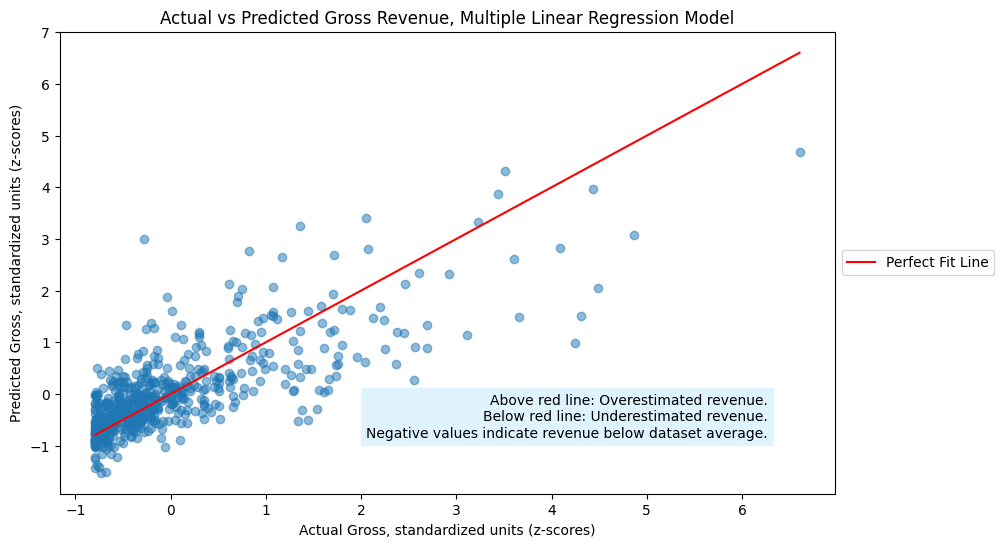

In [325]:
# Set plot details
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit Line')
plt.title('Actual vs Predicted Gross Revenue, Multiple Linear Regression Model')
plt.xlabel('Actual Gross, standardized units (z-scores)')
plt.ylabel('Predicted Gross, standardized units (z-scores)')

# Linking the legend to the plot elements and moving it to the center right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Adding the text box with additional information and placing it in the lower right
plt.text(max(y_test) * 0.95, min(y_test) * 1.05,
         "Above red line: Overestimated revenue.\n"
         "Below red line: Underestimated revenue.\n"
         "Negative values indicate revenue below dataset average.",
         ha='right', fontsize=10, bbox=dict(facecolor='#cceeff', edgecolor='none', alpha=0.6))

# Display the plot
plt.show()

In [326]:
# The model explains about 58% of the variation in movie revenue based on the factors included, indicating a decent fit.
# However, 43% of the variation remains unexplained, suggesting that other influences not captured by the model may be contributing.
# The error rate (0.4236) shows how close the predictions are to actual values, but we need to compare it with other models to see how reliable it really is

In [361]:
# STEP 3.2. RANDOM FOREST MODEL accounting BOTH numerical and categorical features

# Remove 'profit' column from our data
movies_rf = movie_data.drop('profit', axis=1)
# Drop 'movie_title' from the data
if 'movie_title' in movies_rf.columns:
    movies_rf = movies_rf.drop(['movie_title'], axis=1)

# Selecting independable features and target
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color' ]

X = movies_rf[features]
y = movies_rf['gross']

# One-hot encoding categorical columns using pd.get_dummies()
X = pd.get_dummies(X, columns=['genres', 'content_rating', 'language','actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color' ], drop_first=True)

# Standard Scaling for numerical columns
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster', 'movie_facebook_likes', 'imdb_score']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Score, Random Forest, all features: {r2}')
print(f'MEAN SQUARED ERROR, Random Forest, all features: {mse}')



R^2 Score, Random Forest, all features: 0.6797875941774495
MEAN SQUARED ERROR, Random Forest, all features: 1640827011902595.2


In [340]:
# The Random Forest Model that accounts both categorical and scaled numeric features
# has the highest accuracy rates as R² score is higher (0.68-0.69 depends on the run) and MSE is lower.
# This is a 0.12 score improvement in accuracy rate comparing to the initial Multiple Linear Regression model

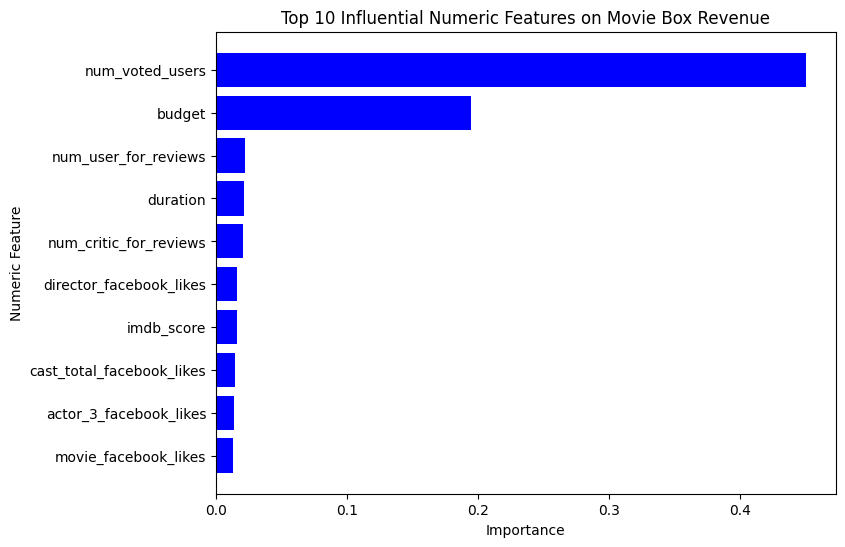

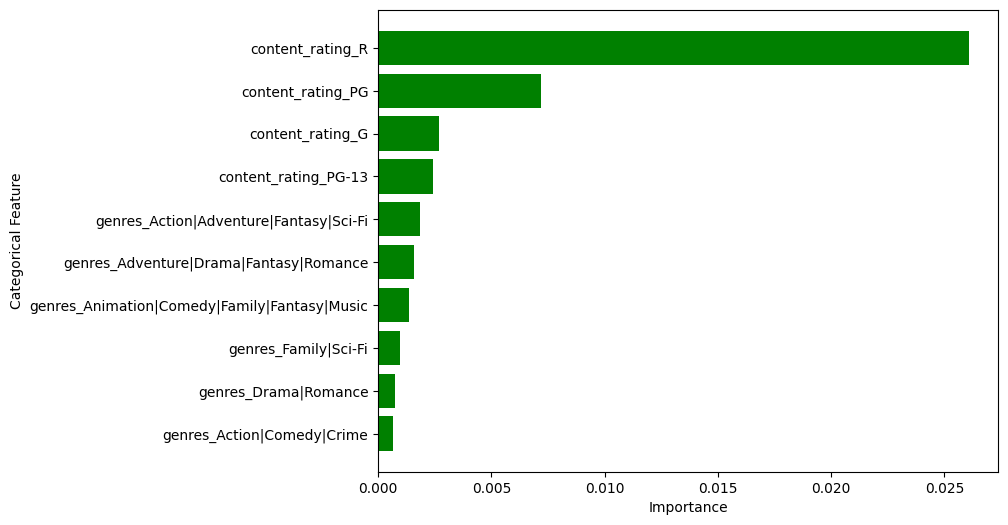

In [362]:
# This code evaluates FEATURE IMPORTANCE for both numerical and categorical features
# Extracting feature importances from the model
importances = model.feature_importances_

# Get the correct feature names (if some features were dropped during preprocessing, align them)
if len(importances) == len(X.columns):
    all_feature_names = X.columns
else:
    all_feature_names = X.columns[:len(importances)]  # Adjust if necessary

# Creating a DataFrame for feature importances
features_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

# Identifying one-hot encoded categorical features based on their prefixes
categorical_encoded_features = [col for col in all_feature_names if any(col.startswith(prefix) for prefix in categorical_features)]

# Identify numeric features (columns of type 'int64' or 'float64')
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creating DataFrames for numeric and categorical features
numeric_importance_df = features_importance_df[features_importance_df['Feature'].isin(numeric_features)]
categorical_importance_df = features_importance_df[features_importance_df['Feature'].isin(categorical_encoded_features)]

# Sorting and selecting the top 10 most influential features for each type
top_numeric_features = numeric_importance_df.sort_values(by='Importance', ascending=False).head(10)
top_categorical_features = categorical_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top 10 numeric features
plt.figure(figsize=(8, 6))
plt.barh(top_numeric_features['Feature'][::-1], top_numeric_features['Importance'][::-1], color='blue')
plt.xlabel('Importance')
plt.ylabel('Numeric Feature')
plt.title('Top 10 Influential Numeric Features on Movie Box Revenue')
plt.show()

# Plotting the top 10 categorical features
plt.figure(figsize=(8, 6))
plt.barh(top_categorical_features['Feature'][::-1], top_categorical_features['Importance'][::-1], color='green')
plt.xlabel('Importance')
plt.ylabel('Categorical Feature')
plt.title('Top 10 Categorical Numeric Features on Movie Box Revenue')
plt.show()

In [363]:
# Output the top 10 numeric and categorical features with their importance scores
print("Top 10 Numeric Features and Their Importance Scores:")
print(top_numeric_features)

print("\nTop 10 Categorical Features and Their Importance Scores:")
print(top_categorical_features)

Top 10 Numeric Features and Their Importance Scores:
                      Feature  Importance
8             num_voted_users    0.450920
0                      budget    0.194484
7        num_user_for_reviews    0.022214
5                    duration    0.021747
6      num_critic_for_reviews    0.020473
4     director_facebook_likes    0.016492
12                 imdb_score    0.016041
9   cast_total_facebook_likes    0.014630
3      actor_3_facebook_likes    0.013636
11       movie_facebook_likes    0.012812

Top 10 Categorical Features and Their Importance Scores:
                                          Feature  Importance
667                              content_rating_R    0.026069
664                             content_rating_PG    0.007190
659                              content_rating_G    0.002706
665                          content_rating_PG-13    0.002419
94         genres_Action|Adventure|Fantasy|Sci-Fi    0.001835
319        genres_Adventure|Drama|Fantasy|Romance    0.

In [365]:
# STEP 3.3. RANDOM FOREST MODEL with engineering features
# calculated new features and  assigned into bins based on 'budget_category' and 'revenue_category'

# Make a cooy of the original cleaned data
movies_adj = movie_data.copy()


In [367]:
# Further look at our data: Determine the number of unique values in each column
# to explore the possibility of binning rare values in nearon network models
unique_values = movies_adj.nunique()
print(unique_values)

gross                        2934
budget                        296
actor_1_name                 1153
actor_1_facebook_likes        596
actor_2_name                 1784
actor_2_facebook_likes        789
actor_3_name                 2121
actor_3_facebook_likes        851
director_name                1386
director_facebook_likes       362
duration                      140
title_year                     68
num_critic_for_reviews        503
num_user_for_reviews          869
num_voted_users              2921
cast_total_facebook_likes    2688
facenumber_in_poster           19
movie_facebook_likes          578
plot_keywords                2945
genres                        647
language                        9
country                         1
content_rating                 11
imdb_score                     74
color                           2
dtype: int64


In [368]:
# Define a function to classify movies by budget according to industry criteria:
# Micro-Budget=1, Low-Budget=2, Mid-Budget=3, High-Budget=4, Blockbuster=5.
def classify_budget(budget):
    if budget < 1000000:
        return '1'
    elif 1000000 <= budget < 10000000:
        return '2'
    elif 10000000 <= budget < 50000000:
        return '3'
    elif 50000000 <= budget < 100000000:
        return '4'
    else:
        return '5'

# Apply the function to the 'budget' column to create a new 'budget_category' column
movies_adj['budget_category'] = movies_adj['budget'].apply(classify_budget)

# Check the transformation
print(movies_adj['budget_category'].value_counts())
# Display the table
print(movies_adj[['budget', 'budget_category']].head(3))

budget_category
3    1447
4     567
2     525
5     279
1     127
Name: count, dtype: int64
        budget budget_category
0  237000000.0               5
1  300000000.0               5
2  250000000.0               5


In [369]:
# Define a function to classify movies by gross box revenue according to industry criteria:
# Micro-Revenue=1, Low-Revenue=2, Mid-Revenue=3, High-Revenue=4, Blockbuster=5.
def classify_revenue(gross):
    if gross < 1000000:
        return '1'
    elif 1000000 <= gross < 10000000:
        return '2'
    elif 10000000 <= gross < 50000000:
        return '3'
    elif 50000000 <= gross < 100000000:
        return '4'
    else:
        return '5'

# Apply the function to the 'gross' column to create a new 'revenue_category' column
movies_adj['revenue_category'] = movies_adj['gross'].apply(classify_revenue)

# Check the transformation
print(movies_adj['revenue_category'].value_counts())

# Display the table
print(movies_adj[['gross', 'revenue_category', 'budget_category']].tail(3))

revenue_category
3    1165
4     591
5     529
2     427
1     233
Name: count, dtype: int64
          gross revenue_category budget_category
2942  2040920.0                2               1
2943     4584.0                1               1
2944    85222.0                1               1


In [370]:
# Display the columns names and their data types
print(movies_adj.dtypes)

gross                        float64
budget                       float64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                     float64
title_year                     int64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color                         object
budget_category               object
revenue_category              object
d

In [372]:
# Convert 'budget_category' and 'revenue_category' from object type to integer
movies_adj['budget_category'] = movies_adj['budget_category'].astype(int)
movies_adj['revenue_category'] = movies_adj['revenue_category'].astype(int)

# Filter 'revenue_category' to be within the range 1 to 5
movies_adj = movies_adj[movies_adj['revenue_category'].between(1, 5)]

# Drop 'budget' and 'gross' columns only if they exist
columns_to_drop = ['budget', 'gross']
movies_adj = movies_adj.drop(columns=[col for col in columns_to_drop if col in movies_adj.columns], axis=1)

# Separate features and target variable
X = movies_adj.drop('revenue_category', axis=1)  # Features
y = movies_adj['revenue_category']  # Target

# Encode categorical features using pd.get_dummies() for 'budget_category' if it exists
columns_to_encode = ['budget_category']
columns_to_encode = [col for col in columns_to_encode if col in X.columns]

# Encode categorical features
X = pd.get_dummies(X, columns=columns_to_encode, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column transformers for numerical and categorical features
numeric_features = X_train.select_dtypes(exclude="object").columns
categorical_features = X_train.select_dtypes(include="object").columns

# Create pipelines for numeric values using StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create pipelines for categorical data processing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with the Random Forest model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate accuracy # Model evaluation for Classification Tasks
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest model with engineered features: {accuracy:.2f}')

Accuracy of the Random Forest model with engineered features: 0.56


In [350]:
#  RESULT: Implementing feature engineering like binning sligthly decreased our accuracy rates.

In [378]:
# STEP 3.4. RANDOM FOREST MODEL using classes for 'profit' only (1 engineering feature)
# Create a copy of the original cleaned data
movies_classes = movie_data.copy()

In [380]:
# Calculate Profit Margin (%) and create a new column
movies_classes['profit_margin'] = (movies_classes['profit'] / movies_classes['gross']) * 100
# Calculate ROI (%) and create a new column
movies_classes['ROI'] = (movies_classes['profit'] / movies_classes['budget']) * 100

# Define the function to classify movies based on Profit Margin and ROI
# Classified based on the industry standards:
# Highly Profitable = 5, Moderately Profitable = 4,
# Marginally Profitable = 3, Break-even = 2, Unprofitable = 1
def classify_profit_margin_and_roi(margin, roi):
    if margin > 50 and roi > 100:
        return '5'
    elif 20 < margin <= 50 and roi > 50:
        return '4'
    elif 0 < margin <= 20 and roi > 0:
        return '3'
    elif margin == 0 and roi == 0:
        return '2'
    else:
        return '1'

# Apply the function to create the 'profit_category' column using both profit_margin and ROI
movies_classes['profit_category'] = movies_classes.apply(lambda row: classify_profit_margin_and_roi(row['profit_margin'], row['ROI']), axis=1)

# Convert 'budget_category' and 'revenue_category' from object type to integer
movies_adj['profit_category'] = movies_classes['profit_category'].astype(int)

# Display the new columns
print(movies_classes[['profit_margin', 'ROI', 'profit_category']].head())


   profit_margin         ROI profit_category
0      68.836532  220.888543               5
1       3.039439    3.134717               3
2      44.212697   79.252257               4
3    -260.942743  -72.294775               1
4      23.335284   30.438102               1


In [381]:
# Defining independent features and target variable
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language',
            'actor_1_name', 'actor_2_name', 'actor_3_name',
            'director_name', 'plot_keywords', 'country', 'color']

X = movies_classes[features]
y = movies_classes['profit_category']

# Encode categorical columns in features using pd.get_dummies()
categorical_columns = ['genres', 'content_rating', 'language',
                       'actor_1_name', 'actor_2_name', 'actor_3_name',
                       'director_name', 'plot_keywords', 'country', 'color']

# Convert all categorical columns to dummy variables
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Encode the target variable ('profit_category') using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standard Scaling for numerical columns
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster',
                      'movie_facebook_likes', 'imdb_score']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Building the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation for Classification Tasks
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.94      0.73       293
           1       1.00      0.02      0.04        52
           2       0.00      0.00      0.00        61
           3       0.72      0.49      0.58       183

    accuracy                           0.62       589
   macro avg       0.58      0.36      0.34       589
weighted avg       0.61      0.62      0.55       589


Confusion Matrix:
[[276   0   1  16]
 [ 40   1   0  11]
 [ 54   0   0   7]
 [ 93   0   1  89]]


In [354]:
# RESULTS: An accuracy of 0.62 in classification means the model above correctly predicted 62% of the cases,
# while an R-squared of 0.69 in regression (Randmom Forest model accounting both categorical and scaled numerical features)
# indicates the model explains 69% of the variance in the data.
#Generally, an R-squared of 0.69 suggests better performance than an accuracy of 0.62.


In [ ]:
# Step 3.5 RANDOM FOREST MODEL with Hyperparameter Tuning
# GridSearchCV took too long to execute, therefore we went with another option.

In [383]:
# Make a cooy of the original cleaned data
movies_ht = movie_data.copy()

In [ ]:
# This code enables parallelization for faster processing
# Define the features and target variable
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language',
            'actor_1_name', 'actor_2_name', 'actor_3_name',
            'director_name', 'plot_keywords', 'country', 'color']

target = 'gross'

# Extract features and target
X = movies_ht[features]
y = movies_ht[target]

# Separate numerical and categorical features
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster',
                      'movie_facebook_likes', 'imdb_score']

categorical_features = ['content_rating', 'language', 'actor_1_name', 'actor_2_name',
                        'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color']

# Create pipelines for numeric and categorical data processing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with the Random Forest model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up the parameter distribution for hyperparameter tuning
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomizedSearchCV with parallelization (n_jobs=-1)
random_search = RandomizedSearchCV(estimator=model_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=20,  # Number of random combinations to try
                                   cv=5,
                                   scoring='r2',
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores for parallel processing

# Fit the random search to the training data
try:
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

    # Train the Random Forest model with the best parameters
    best_model = random_search.best_estimator_

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the model's performance using R-squared
    r2 = r2_score(y_test, y_pred)
    print(f'R-squared of the tuned Random Forest model: {r2:.2f}')
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error of the tuned Random Forest model: {mse:.2f}')
except ValueError as e:
    print("Error during random search fitting:", e)

In [ ]:
# This code is also uses Hyperparameter Tuning, but without enabling parallelization (may take up to 45 minutes based on data size)
# Make a copy of the original cleaned data
movies_rfht = movie_data.copy()

# Define the features and target variable
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language',
            'actor_1_name', 'actor_2_name', 'actor_3_name',
            'director_name', 'plot_keywords', 'country', 'color']

target = 'gross'

# Extract features and target
X = movies_rfht[features]
y = movies_rfht[target]

# Separate numerical and categorical features
numerical_features_rfht = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster',
                      'movie_facebook_likes', 'imdb_score']

categorical_features_rfht = ['content_rating', 'language', 'actor_1_name', 'actor_2_name',
                        'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color']

# Create pipelines for numeric and categorical data processing
numeric_transformer_rfht = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_rfht = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor_rfht = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with the Random Forest model
model_pipeline_rfht = Pipeline(steps=[
    ('preprocessor', preprocessor_rfht),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up the parameter distribution for hyperparameter tuning
param_dist = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomizedSearchCV without parallelization
random_search = RandomizedSearchCV(estimator=model_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=10,  # Number of random combinations to try
                                   cv=3,  # Reduce CV folds for faster performance
                                   scoring='r2',
                                   random_state=42,
                                   n_jobs=1)  # Use only 1 core, i.e., no parallelization

# Measure the time it takes for random search to execute
start_time = time.time()

try:
    # Fit the random search to the training data
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

    # Train the Random Forest model with the best parameters
    best_model = random_search.best_estimator_

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the model's performance using R-squared
    r2 = r2_score(y_test, y_pred)
    print(f'R-squared of the tuned Random Forest model: {r2:.2f}')
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error of the tuned Random Forest model: {mse:.2f}')

    # Display running time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for RandomizedSearchCV: {elapsed_time:.2f} seconds")

except ValueError as e:
    print("Error during random search fitting:", e)